In [1]:
'''
###
Term frequency and Document frequency for EHR medical terms.

Drop the least informative terms (among filter_out) with high relative TF and DF.
Plot the distribution of (collection_frequency/collection) * (patient_frequency/patient).
Return the list of stop words.
###
'''
import os
import csv
import numpy as np

disease_folder = 'autism'
datetime_folder = '2018-10-23-17-35-48'

folder = os.path.expanduser('~/data1/complex_disorders/data/%s/cohorts/%s/' % (disease_folder, datetime_folder))

##Terms to filter, distribution threshold. 
filter_out = ['medication']

with open(os.path.join(folder, 'cohort-vocab.csv')) as f:
    rd = csv.reader(f)
    next(rd)
    lab_vocab = []
    for r in rd:
        lab_vocab.append([r[0], int(r[1])])

with open(os.path.join(folder, 'cohort-ehr.csv')) as f:
    rd = csv.reader(f)
    next(rd)
    ehr_seq = {}
    for r in rd:
        ehr_seq.setdefault(r[0], list()).extend([int(r[1])])

In [2]:
##Compute the collection frequency for each clinical term
coll_freq = []
for lv in lab_vocab:
    counts = [ehr_seq[m].count(lv[1]) for m in ehr_seq]
    doc_freq = len(list(filter(lambda x: x!=0, counts)))
    coll_freq.append([lv[1], sum(counts), doc_freq])

In [3]:
##P(t)*P(t in p), where t is the clinical term and p is a patient
T = sum([len(ehr_seq[m]) for m in ehr_seq])
N = len(ehr_seq)

fr = []
for l in coll_freq:
    tmp = l[1]/T * l[2]/N
    fr.append(tmp)
    l.append(tmp)

In [4]:
coll_freq_sorted = sorted(coll_freq, key=lambda x: x[3]) ##sort by the probability product

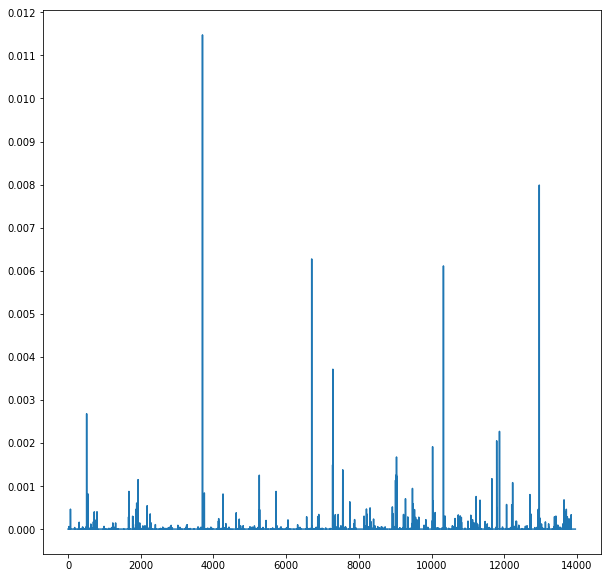

In [5]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=[10,10])
plt.yticks(np.arange(0, 0.1, 0.001))
plt.plot(fr)

In [6]:
thresh = 0.002
stop_words = []
for cfs in reversed(coll_freq_sorted):
    if cfs[3] >= thresh or cfs[3] <= (1/N*1/T):
        print(lab_vocab[cfs[0]-1], cfs[1::])
        for fo in filter_out:
            if lab_vocab[cfs[0]-1][0].find(fo)!=-1:
                stop_words.append(cfs[0])

['icd9::Multiple myeloma, without mention of having achieved remission::203.00::C2349260', 3699] [129981, 2731, 0.011476392032637037]
['medication::Sodium chloride::9863::C0037494', 12965] [61285, 4032, 0.007988744198437881]
['icd9::Unspecified essential hypertension::401.9::C0085580', 6704] [48354, 4013, 0.006273434488948038]
['medication::Injection::1649574::C1272883', 10328] [48781, 3875, 0.006111195921058527]
['medication::Acetaminophen::161::C0000970', 7286] [30370, 3781, 0.0037124043302600067]
["icd9::Alzheimer's disease::331.0::C0002395", 512] [28288, 2929, 0.0026787082565565396]
['medication::Oxycodone::7804::C0030049', 11870] [23542, 2982, 0.0022696286017332523]
['medication::Ondansetron::26225::C0061851', 11793] [24066, 2635, 0.002050162725335935]
['medication::{12 (dexamethasone 0.75 mg oral tablet [decadron]) } pack [decadron 5-12]::795716::C0874621', 13957] [1, 1, 3.232985831241025e-11]
['medication::zytrec', 13956] [1, 1, 3.232985831241025e-11]
['medication::zinlori', 139

In [7]:
print("Discard {0} terms".format(len(stop_words)))

Discard 1899 terms


In [9]:
##Write files stop_words.csv and collection_frequencies.csv

with open(os.path.join(folder, 'stop-words.csv'), 'w') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_NONE)
    wr.writerows([stop_words])
    
with open(os.path.join(folder, 'collection-frequencies.csv'), 'w') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_NONE)
    wr.writerow(["EVENT", "COLLECTION_FREQUENCY", "PATIENT_FREQUENCY", "CF*PF"])
    for el in coll_freq:
        wr.writerow(el)